In [6]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pickle



In [7]:
# Load the dataset from a pickle file
house_full = pd.read_pickle('house_full.pkl')

In [8]:
seed =42

In [9]:
# Define the target variable and features

X = house_full.drop("median_house_value", axis=1)
y = house_full["median_house_value"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



The first algorithm selected for further enhancement is XGBoost. I will start by performing a parameter grid search to identify the optimal parameters that can improve the model's performance. To ensure robustness and reduce overfitting, I will use 5-fold cross-validation during the grid search process to validate the model across different subsets of the data.

## Model 1: XGBoost

In [10]:
# Defining the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0] }

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=seed),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE as scoring metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fitting the model to the training data
grid_search.fit(X_train, y_train)

# Best estimator and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Printing the best parameters
print("Adjusted Best Model Parameters:")
print(best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Adjusted Best Model Parameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}


In [11]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

In [12]:
# Predicting on training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculating metrics for training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# DataFrame for the metrics
metrics = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], test_metrics['R2']]
})

# Displaying the metrics DataFrame
print("Model Performance Metrics:")
print(metrics)

Model Performance Metrics:
    Dataset          RMSE           MSE           MAE        R2
0  Training  25777.488725  6.644789e+08  17857.392730  0.949801
1      Test  41299.541753  1.705652e+09  27197.583248  0.875274


I have evaluated the model's performance metrics on both the training and test sets to verify and double-check for potential overfitting. This comparison ensures the model generalizes well to unseen data while maintaining strong performance on the training set.

In this case, the result shows clear signs of overfitting: 
- In the training set we can see very low error metrics (RMSE: 25,777, MAE: 17,857) and a high R² of 0.95, indicating that the model fits the training data exceptionally well.
- In the test set, error metrics are notably higher (RMSE: 41,209, MAE: 27,111), and R² drops to 0.875. This indicates the model generalizes well but is overfitting the training data, as the performance gap between training and test sets is significant.

My approach will focus on adjusting the parameter grid to make the model less complex, which should help reduce overfitting. Specifically, I will fine-tune parameters like max_depth (to control tree size) and eta (learning rate) to strike a better balance between bias and variance. Additionally, I will incorporate regularization parameters L1 (alpha) and L2 (lambda):
- L1 Regularization (alpha) helps by encouraging sparsity in the model, shrinking less important features weights to zero. This simplifies the model and reduces overfitting.
- L2 Regularization (lambda) penalizes large coefficients, helping to stabilize the model and improve generalization by reducing variance.

In [13]:
# Adjusted parameter grid to reduce overfitting
param_grid = {
    'n_estimators': [50, 100],  # Fewer trees to reduce overfitting
    'learning_rate': [0.01, 0.05, 0.1],  # Smaller learning rate
    'max_depth': [2, 3, 4],  # Shallower trees
    'subsample': [0.7, 0.8],  # Fraction of training samples used
    'colsample_bytree': [0.7, 0.8],  # Fraction of features used per tree
    'reg_alpha': [0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 2]  # L2 regularization
}

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=seed),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Use RMSE as scoring metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fitting the model to the training data
grid_search.fit(X_train, y_train)

# Best estimator and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Printing the best parameters
print("Best Model Parameters:")
print(best_params)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Model Parameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


In [14]:
# Predicting on training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculating metrics for training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# DataFrame for the metrics
metrics = pd.DataFrame({
    'model_id': ['Training', 'Test'],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], test_metrics['R2']]
})

# Displaying the metrics DataFrame
print("Model Performance Metrics:")
print(metrics)

Model Performance Metrics:
   model_id          RMSE           MSE           MAE        R2
0  Training  41910.407186  1.756482e+09  29265.235541  0.867304
1      Test  45937.933582  2.110294e+09  31481.250088  0.845684


- The performance gap between the training and test sets has narrowed compared to the previous model. This indicates that the adjustments to reduce complexity and add regularization parameters (L1 and L2) successfully mitigated overfitting.
- The R² for both datasets is closer now, showing better generalization, with the test set still maintaining acceptable predictive power (R² = 0.846).<br>
- The introduction of regularization (L1 and L2) and reduced model complexity successfully addressed overfitting, improving the balance between training and test set performance. Although the model is slightly less precise on the training data, its ability to generalize to unseen data has improved, making it more robust and reliable.

In [15]:
# Extracting only the test metrics and rename
models_metrics = metrics[metrics['model_id'] == 'Test'].copy()
models_metrics['model_id'] = 'XGBoost'

In [16]:
#Empty data frame
performance_manual = pd.DataFrame()

# Appending the metrics as a new row in the DataFrame
performance_manual = pd.concat([performance_manual, models_metrics], ignore_index=True)

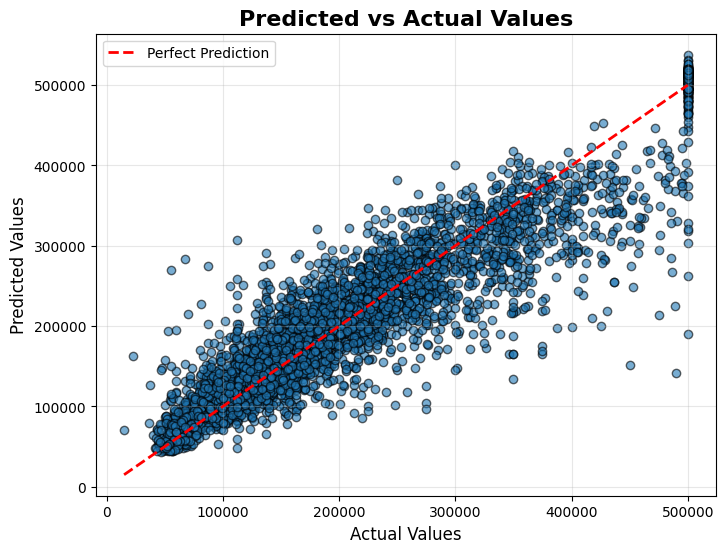

In [17]:
# Scatter plot: Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Predicted vs Actual Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

- The Predicted vs Actual Values graph shows that the majority of points are well aligned with the red dashed perfect prediction line, indicating good predictive accuracy.
- The vertical clustering at the capped value (500,001) persists, similar to the earlier AutoML models. 

In [18]:
# Feature importance scores based on gain
feature_importance_gain = best_model.get_booster().get_score(importance_type='gain')

# Converting to DataFrame for sorting and interpretation
feature_importance_gain_df = pd.DataFrame({
    'Feature': feature_importance_gain.keys(),
    'Importance': feature_importance_gain.values()
}).sort_values(by='Importance', ascending=False)

# Displaying the top 10 features
print("Top 10 Features by Gain:")
print(feature_importance_gain_df.head(10))


Top 10 Features by Gain:
                     Feature    Importance
18                 is_capped  3.850841e+12
14    ocean_proximity_INLAND  3.106725e+12
7              median_income  1.384912e+12
11          rooms_per_capita  5.706572e+11
10  population_per_household  4.130950e+11
8        rooms_per_household  3.338723e+11
9          bedrooms_per_room  2.517711e+11
1                   latitude  2.444423e+11
0                  longitude  1.956375e+11
12      location_interaction  1.536356e+11


C:\Users\rudyh\AppData\Local\Temp\ipykernel_16764\2132985209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


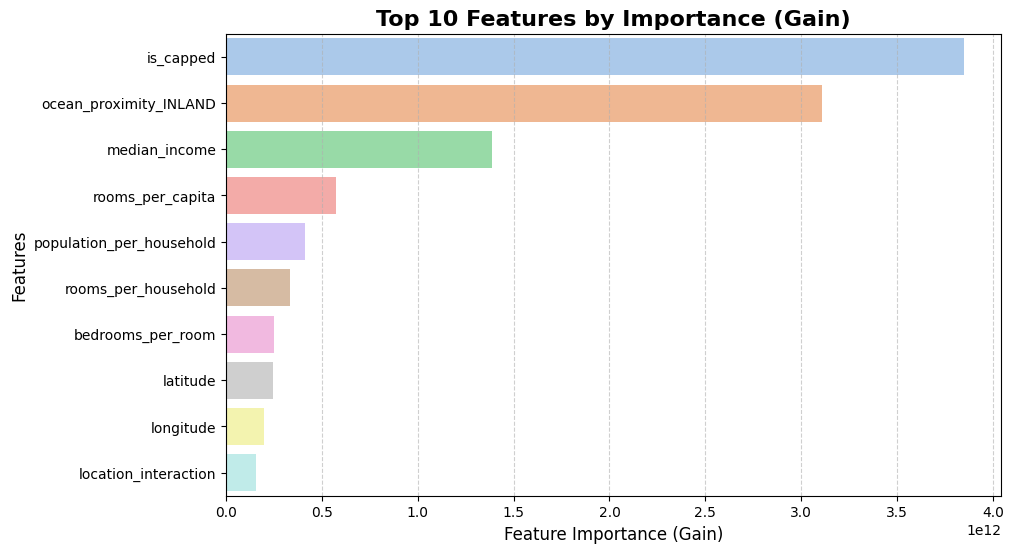

In [19]:
# Plotting the top 10 features by gain
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', y='Feature', data=feature_importance_gain_df.head(10),
    palette='pastel')
plt.title('Top 10 Features by Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In XGBoost, feature importance based on gain measures the average improvement in model performance (reduction in loss) brought by a feature whenever it is used to split a node in the decision trees. Features with higher gain contribute more to the model’s predictive accuracy, as they provide the most valuable information for reducing errors. I'm using this metric (gain) to display the most important features for the model. 

- is_capped: The addition of this feature has been highly impactful, as it directly addresses the capped values, a known issue in the dataset.
- Features like ocean_proximity, latitude, and longitude highlight the significant role of location in predicting housing prices.
- The INLAND and NEAR OCEAN categories dominate, indicating strong regional differences.
- Median_income remains one of the most influential predictors, reinforcing its correlation with housing prices.
- Features like rooms_per_capita and population_per_household provide additional granularity on housing density and household size.

The top features emphasize the importance of economic indicators, location-based factors, and housing layout in predicting property values.

## Model 2: Light GBM

The second model I will test is LightGBM. Building on the experience with XGBoost, I will start with a simpler model and apply L1 and L2 regularization right from the beginning.

In [20]:
# Parameter grid
param_grid = {
    'num_leaves': [15, 25],              
    'max_depth': [5, 10],               
    'learning_rate': [0.05, 0.1],       
    'n_estimators': [100, 500],         
    'subsample': [0.8],                 
    'colsample_bytree': [0.8],          
    'reg_alpha': [0.1],                 # L1 regularization for sparsity
    'reg_lambda': [0.1]                 # L2 regularization for stability
}


# Creating the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=seed)

# Setting up GridSearchCV 
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=5,                                # 5-fold cross-validation
    scoring='neg_mean_squared_error',    # Optimize for negative MSE
    verbose=1,
    n_jobs=-1                            # Use all processors
)

# Training the model using grid search
grid_search.fit(X_train, y_train)

# Best model and parameters
best_lgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 18
[LightGBM] [Info] Start training from score 206644.400098


In [21]:
# Best Parameters
print("Best Parameters for LightGBM:")
print(best_params)

Best Parameters for LightGBM:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 25, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}


In [22]:
# Predict on training and test sets
y_train_pred = best_lgb_model.predict(X_train)
y_test_pred = best_lgb_model.predict(X_test)

# Calculate metrics for training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], test_metrics['R2']]
})

# Display the metrics DataFrame
print("Model Performance Metrics:")
print(metrics)

Model Performance Metrics:
    Dataset          RMSE           MSE           MAE        R2
0  Training  24562.435821  6.033133e+08  17158.112701  0.954422
1      Test  40637.330150  1.651393e+09  26607.776893  0.879242


- The training error (RMSE = 24,562, MAE = 17,158) is significantly lower than the test error (RMSE = 40,637, MAE = 26,608).This gap indicates that the model fits the training data very well but struggles slightly more on unseen data, which suggests some level of overfitting.
- The R² score drops from 0.954 on the training set to 0.879 on the test set, a decrease of 7.5 percentage points. While the drop is moderate, it reflects that the model's performance on new data is not as strong as on the training data.
- Despite L1 and L2 regularization, there is still a slight overfitting tendency.

While the performance gap between the training and test sets suggests some overfitting, it remains moderate, and the model generalizes fairly well. Nevertheless, I will make further adjustments to reduce this gap even more.

I will fine-tune the parameter grid to simplify the model further and increase L1 and L2 regularization in an effort to reduce overfitting.

In [23]:
# Parameter grid
param_grid = {
    'num_leaves': [10, 20],              # Smaller trees to reduce complexity
    'max_depth': [3, 5],                 # Restricting depth of trees
    'learning_rate': [0.03],             # Lower learning rates for gradual learning
    'n_estimators': [500],               # Fewer boosting iterations
    'subsample': [0.4, 0.6],             # Subsample data for each tree
    'colsample_bytree': [0.4,0.6],       # Using a fraction of features for training
    'reg_alpha': [10, 20],               # Increasing L1 regularization
    'reg_lambda': [10, 20]               # Increasing L2 regularization
}

# Create the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=seed)

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=5,                                 # 5-fold cross-validation
    scoring='neg_mean_squared_error',     # Use negative MSE as the scoring metric
    verbose=1,
    n_jobs=-1                             # Use all processors
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_lgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 18
[LightGBM] [Info] Start training from score 206644.400098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [24]:
print("Best Parameters for LightGBM:")
print(best_params)

Best Parameters for LightGBM:
{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.4}


In [25]:
# Using the best parameters to refit the model with early stopping
best_lgb_model = lgb.LGBMRegressor(**best_params, random_state=seed)

# Enable early stopping with callbacks
callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

# Refit the model with the best parameters and early stopping
best_lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=callbacks
)

# Predict on training and test sets
y_train_pred = best_lgb_model.predict(X_train)
y_test_pred = best_lgb_model.predict(X_test)

# Calculate metrics for training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'model_id': ['Training', 'Test'],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], test_metrics['R2']]
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 206644.400098
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [26]:
# Display the metrics DataFrame
print("Model Performance Metrics:")
print(metrics)

Model Performance Metrics:
   model_id          RMSE           MSE           MAE        R2
0  Training  37975.744608  1.442157e+09  25955.035877  0.891050
1      Test  43125.842838  1.859838e+09  29009.428930  0.863999


- The performance gap between the training and test sets has narrowed further compared to the previous model, indicating that the additional regularization and reduced complexity effectively addressed overfitting.
- Training R² dropped slightly from 0.954 to 0.891, while Test R² remained stable at 0.864, suggesting a better balance between fit and generalization.
- While the test RMSE increased slightly (from 40,637 to 43,126), the improved balance between training and test performance suggests that the model generalizes better overall.
- MAE also reflects better alignment between training and test results, with the gap narrowing (Training MAE = 25,955 vs. Test MAE = 29,009).

In [27]:
# Extracting only the test metrics and rename
models_metrics2 = metrics[metrics['model_id'] == 'Test'].copy()
models_metrics2['model_id'] = 'LightGBM'

In [28]:
# Appending the metrics as a new row in the DataFrame
performance_manual = pd.concat([performance_manual, models_metrics2], ignore_index=True)

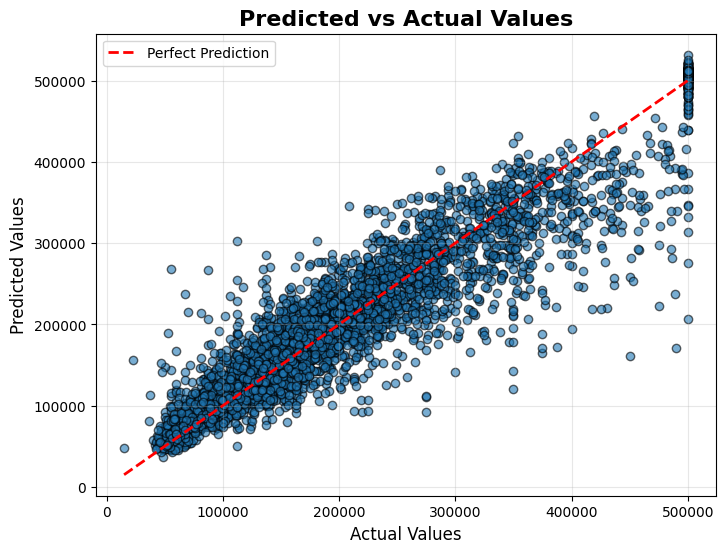

In [29]:
# Scatter plot: Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Predicted vs Actual Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

- LightGBM shows a slightly tighter alignment of points around the perfect prediction line, particularly for mid-range values (100,000–400,000).XGBoost had a wider spread in this range, with more visible residual errors.
- Both models have vertical clustering at the 500,001 cap, but LightGBM's predictions appear more concentrated and less scattered than XGBoost's.While the difference isn’t drastic, it suggests that LightGBM manages capped values with slightly better stability.
- LightGBM shows fewer extreme outliers compared to XGBoost, where some predictions deviated more significantly, particularly for higher actual values.

In [30]:
# Extract feature importances based on gain
feature_importances_gain = best_lgb_model.booster_.feature_importance(importance_type='gain')
features = X_train.columns

# Create a DataFrame for feature importances
importance_gain_df = pd.DataFrame({
    'Feature': features,
    'Importance (Gain)': feature_importances_gain
}).sort_values(by='Importance (Gain)', ascending=False)

C:\Users\rudyh\AppData\Local\Temp\ipykernel_16764\2788904480.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


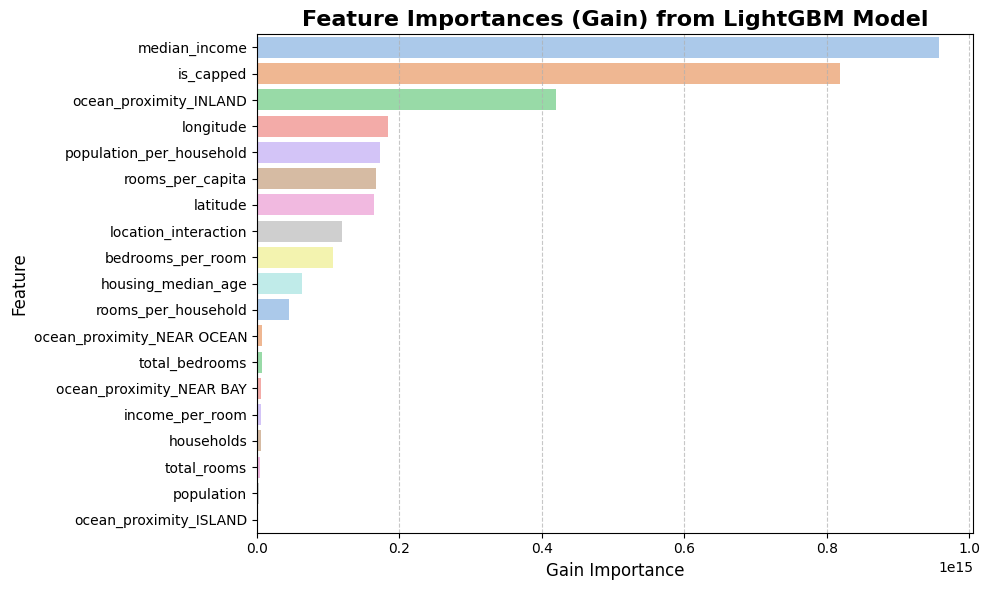

In [31]:
# Plot feature importances (based on gain)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance (Gain)', 
    y='Feature', 
    data=importance_gain_df,
    palette='pastel'  # Use pastel colors
)
plt.title('Feature Importances (Gain) from LightGBM Model', fontsize=16, fontweight='bold')
plt.xlabel('Gain Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Since is_capped dominates feature importance, it shows that the capped values ($500,001) hold distinct characteristics that affect the model's predictions significantly.
This reinforces the idea that adding the is_capped variable was beneficial for the model, helping it handle the 4.69% of data points that were capped.

In [32]:
# Save the model to a pickle file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

## Model 3: Random Forest

The final algorithm showing good performance in initial test is Random Forest. As with the previous models, I will aim to keep the model simple to minimize the risk of overfitting.

In [33]:
# Parameter grid
param_grid = {
    'n_estimators': [50,100,200],           # Number of trees
    'max_depth': [5, 10, 15],               # Maximum depth of trees
    'min_samples_split': [10, 20],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [10, 20],           # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2'],       # Number of features to consider when looking for the best split
    'bootstrap': [True]                     
}

# Creating the Random Forest model
rf_model = RandomForestRegressor(random_state=seed)

# Setting up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                                 # 5-fold cross-validation
    scoring='neg_mean_squared_error',     # Optimization for negative MSE
    verbose=1,
    n_jobs=-1                             # Using all available processors
)

# Training the model using grid search
grid_search_rf.fit(X_train, y_train)

# Best model and parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_



Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\rudyh\Desktop\Housing\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [34]:
print("Best Parameters for Random Forest:")
print(best_rf_params)

Best Parameters for Random Forest:
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [35]:
# Predict on training and test sets
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Calculate metrics for training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'model_id': ['Training', 'Test'],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'MSE': [train_metrics['MSE'], test_metrics['MSE']],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], test_metrics['R2']]
})

# Display the metrics DataFrame
print("Model Performance Metrics:")
print(metrics)

Model Performance Metrics:
   model_id          RMSE           MSE           MAE        R2
0  Training  38532.940135  1.484787e+09  26200.618191  0.887829
1      Test  46461.541375  2.158675e+09  31559.310681  0.842147


- The R² difference between training (0.8878) and test (0.8421) is relatively small (about 4.5%), indicating that the model is not heavily overfitting.
- Since Random Forests are inherently prone to mild overfitting due to their ensemble structure and the large number of trees learning specific patterns in the training data, I will accept this result as valid. 
- While Random Forest underperforms slightly compared to LightGBM and XGBoost, its performance is still reasonable and demonstrates acceptable generalization to the test set.

In [36]:
# Extract only the test metrics and rename
models_metrics3 = metrics[metrics['model_id'] == 'Test'].copy()
models_metrics3['model_id'] = 'Random Forest'

In [37]:
# Appending the metrics as a new row in the DataFrame
performance_manual = pd.concat([performance_manual, models_metrics3], ignore_index=True)

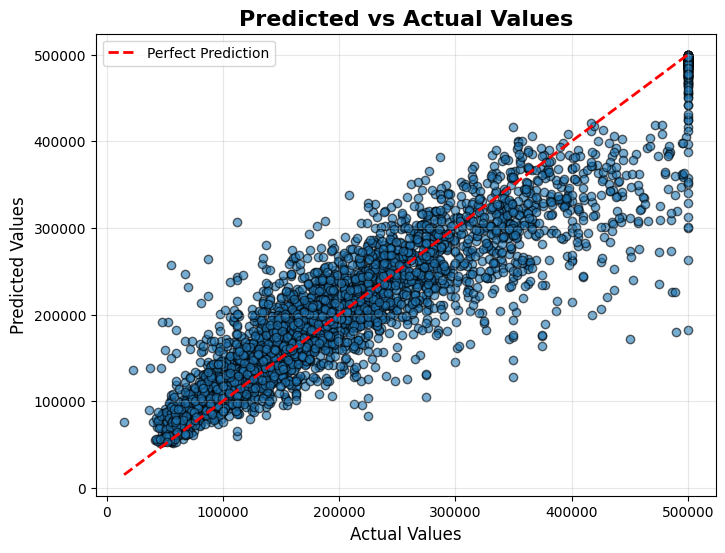

In [38]:
# Scatter plot: Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Predicted vs Actual Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

- The scatter plot has a similar pattern to the previous ones: strong alignment with the spread of points widening slightly at higher values, indicating larger residuals in this range. Nevertheless, the model performs well overall.

C:\Users\rudyh\AppData\Local\Temp\ipykernel_16764\2956554990.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


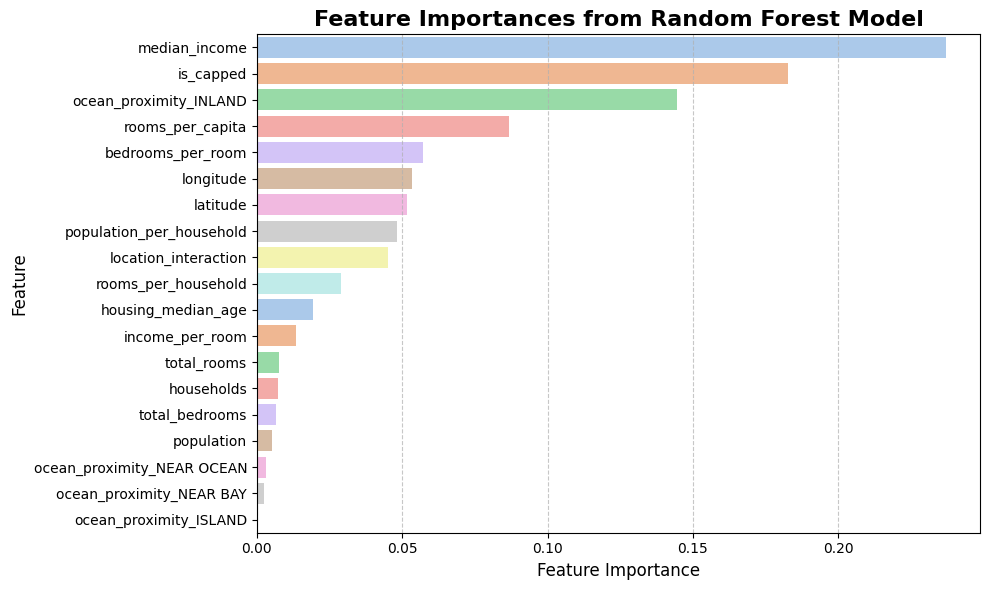

In [39]:
# Extract feature importances from Random Forest
feature_importances = best_rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df,
    palette='pastel'  # Use pastel colors
)
plt.title('Feature Importances from Random Forest Model', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In this case of Random Forest, the feature importance do not represent the 'gain' (a metric specific to gradient-boosted trees like LightGBM or XGBoost).Random Forest computes feature importance based on mean decrease in impurity (Gini importance), which measures how much each feature contributes to reducing the impurity across all splits in the trees. <br>


- The feature importance rankings in the Random Forest model closely align with trends seen in previous models, with median_income, is_capped, and ocean_proximity_INLAND consistently ranking at the top.
- Random Forest appears to balance the use of both raw and engineered features effectively, though the engineered features (rooms_per_capita, bedrooms_per_room) are more influential compared to LightGBM.


**Conclusion about manual models:**
- All three models provide reasonable performance, but LightGBM consistently edges ahead with lower error metrics and better generalization.
- XGBoost performs competitively and remains a strong option.
- Random Forest is the least effective in this case, which may be due to its relatively simple implementation compared to the gradient boosting algorithms' more sophisticated optimization techniques.

In [43]:
performance_manual.to_pickle('performance_manual.pkl')